# OpenEQA QuickStart

Welcome! This notebook is intended to provide a quick-start guide to OpenEQA and its workflow. Before you can start using this notebook, please perform a few basic installation steps.

## Packages and Dependencies
- Install [openeqa](https://github.com/facebookresearch/open-eqa/blob/main/setup.py) and [required packages](https://github.com/facebookresearch/open-eqa/blob/main/requirements.txt).
- You don't need the full dataset to run this notebook and get started. But we highly encourage you to look at instructions to [download the data](https://github.com/facebookresearch/open-eqa/blob/main/data/README.md) and get started early! We realize getting access to the dataset has a few hoops to jump through and thus we provide this repo with a small "demo dataset" to give you a flavor of the benchmark.
- Get API access keys ready for different models (e.g. GPT, Claude) or host the model on your end (e.g. LLaMA, Mixtral).

## Data Visualization

Let's first start by visualizing a demo dataset generated from a [public HM3D scene](https://aihabitat.org/datasets/hm3d/).

In [1]:
import os

import matplotlib.pyplot as plt
from IPython.display import Video

Video("assets/open-eqa-hm3d-demo.mp4", embed=True, width=480)

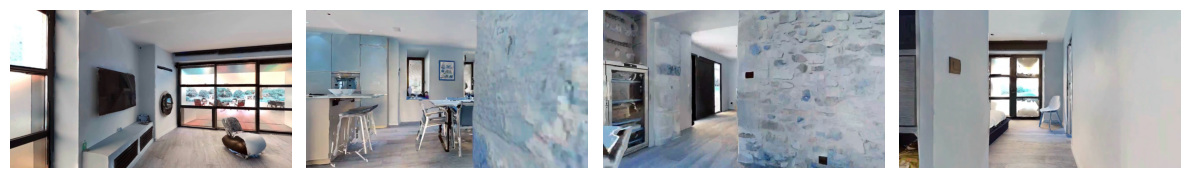

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.54it/s]


In [2]:
from PIL import Image
from tqdm import tqdm

from openeqa.utils.demo_utils import (
    decode_frames_from_video_path,
    get_equally_spaced_frames,
)

frames_per_traj = 15

# get the frames from the video
frames = decode_frames_from_video_path("assets/open-eqa-hm3d-demo.mp4")

# extract equally spaced frames
frames = get_equally_spaced_frames(frames, frames_per_traj)

# display a few frames
_, axs = plt.subplots(1, 4, figsize=(12, 12))
for img, ax in zip(frames[::4], axs):
    ax.axis("off")
    ax.imshow(img)
plt.tight_layout()
plt.show()

# save images to disk
if not os.path.exists("assets/demo_frames/"):
    os.mkdir("assets/demo_frames")
for idx, f in enumerate(tqdm(frames)):
    img = Image.fromarray(f)
    img.save(f"assets/demo_frames/{idx:06d}.png")

## Load the Questions

In [3]:
import json

demo_data = json.load(open("assets/open-eqa-demo-data.json"))
print(json.dumps(demo_data, indent=2))

[
  {
    "question": "How many chairs are around the dining table?",
    "answer": "Eight chairs",
    "category": "object localization",
    "question_id": "f15fbfbb-eb0f-41e7-9d33-bc75e48e62d1",
    "episode_history": "assets/open-eqa-hm3d-demo"
  },
  {
    "question": "If I enter the home through the entrance near the plants, which way should I turn to go to the bedroom?",
    "answer": "Don't turn. Keep walking straight.",
    "category": "spatial understanding",
    "question_id": "de9d3196-2407-4c5a-b3ad-05ed7bf376a2",
    "episode_history": "assets/open-eqa-hm3d-demo"
  },
  {
    "question": "In which room does this home have exercise equipment?",
    "answer": "Bedroom",
    "category": "object localization",
    "question_id": "b0dafc4b-6a1c-4048-913c-90867c124367",
    "episode_history": "assets/open-eqa-hm3d-demo"
  }
]


## Ask the Model

Let's start with a text-only (or blind) LLM. We'll use GPT-4 for illustration, but we encourage you to try out your own model!

First set the OPENAI_API_KEY environment variable to your own openai api key.

In [4]:
assert "OPENAI_API_KEY" in os.environ
from openeqa.baselines.gpt4 import ask_question as ask_blind_gpt4

verbose = True

for item in demo_data:
    q = item["question"]
    a = item["answer"]
    blind_gpt4_a = ask_blind_gpt4(
        question=q,
        openai_model="gpt-4-0613",
    )
    item["blind_gpt4_answer"] = blind_gpt4_a
    if verbose:
        # print the question and the model's answer
        print("Q: {}\nA: {}\n".format(q, blind_gpt4_a))

Q: How many chairs are around the dining table?
A: Four

Q: If I enter the home through the entrance near the plants, which way should I turn to go to the bedroom?
A: This information is not provided in the question. However, in many homes, bedrooms are often located to the right of the entrance. So, you might need to turn right.

Q: In which room does this home have exercise equipment?
A: The home gym or living room.



Next, lets try a multi-modal LLM. We'll use GPT-4V, but other models are implemented in the open-eqa codebase. 

In [5]:
assert "OPENAI_API_KEY" in os.environ
import glob

from openeqa.baselines.gpt4v import ask_question as ask_gpt4v

verbose = True

for item in demo_data:
    q = item["question"]
    image_paths = sorted(glob.glob("assets/demo_frames/*.png"))
    gpt4v_a = ask_gpt4v(
        question=q,
        image_paths=image_paths,
        openai_key=os.environ["OPENAI_API_KEY"],
        openai_model="gpt-4-vision-preview",
    )
    item["gpt4v_answer"] = gpt4v_a
    if verbose:
        # print the question and the model's answer
        print("Q: {}\nA: {}\n".format(q, gpt4v_a))

Q: How many chairs are around the dining table?
A: There are six chairs around the dining table.

Q: If I enter the home through the entrance near the plants, which way should I turn to go to the bedroom?
A: To go to the bedroom after entering the home through the entrance near the plants, you should turn right.

Q: In which room does this home have exercise equipment?
A: The exercise equipment, which appears to be an elliptical trainer, is located in the bedroom.



## Evaluate the Answers w/ LLM-Match

Finally, we'll evaluate the open-vocabulary answers produced by an LLMs or multi-modal LLMs by comparing against the ground truth answer(s) using LLM-Match, which uses a rating of 1-5 to score answers. See the paper for more details.

In [6]:
assert "OPENAI_API_KEY" in os.environ
from openeqa.evaluation.llm_match import get_llm_match_score

# evaluate GPT-4 answers
for item in demo_data:
    c = get_llm_match_score(
        question=item["question"],
        answer=item["answer"],
        prediction=item["blind_gpt4_answer"],
    )  # correctness score (see Eq. 1 and Table 2 in paper)
    item["blind_gpt4_score"] = c

# evaluate GPT-4v answers
for item in demo_data:
    c = get_llm_match_score(
        question=item["question"],
        answer=item["answer"],
        prediction=item["gpt4v_answer"],
    )  # correctness score (see Eq. 1 and Table 2 in paper)
    item["gpt4v_score"] = c

In [7]:
# print the final results
print(json.dumps(demo_data, indent=2))

[
  {
    "question": "How many chairs are around the dining table?",
    "answer": "Eight chairs",
    "category": "object localization",
    "question_id": "f15fbfbb-eb0f-41e7-9d33-bc75e48e62d1",
    "episode_history": "assets/open-eqa-hm3d-demo",
    "blind_gpt4_answer": "Four",
    "gpt4v_answer": "There are six chairs around the dining table.",
    "blind_gpt4_score": 1,
    "gpt4v_score": 1
  },
  {
    "question": "If I enter the home through the entrance near the plants, which way should I turn to go to the bedroom?",
    "answer": "Don't turn. Keep walking straight.",
    "category": "spatial understanding",
    "question_id": "de9d3196-2407-4c5a-b3ad-05ed7bf376a2",
    "episode_history": "assets/open-eqa-hm3d-demo",
    "blind_gpt4_answer": "This information is not provided in the question. However, in many homes, bedrooms are often located to the right of the entrance. So, you might need to turn right.",
    "gpt4v_answer": "To go to the bedroom after entering the home throu